<a href="https://colab.research.google.com/github/brandonso994/AttnLSTMMusicGeneration/blob/main/V2/Train_Model_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install keras_self_attention

  Preparing metadata (setup.py) ... done
  Created wheel for keras_self_attention: filename=keras_self_attention-0.51.0-py3-none-any.whl size=18895 sha256=54ca124faf9aba3186af0e571a4fdef809c6d6a8d14bc4a53a965013f833f514
  Stored in directory: /root/.cache/pip/wheels/b8/f7/24/607b483144fb9c47b4ba2c5fba6b68e54aeee2d5bf6c05302e
Successfully built keras_self_attention


In [ ]:
from music21 import converter, instrument, note, chord, stream, volume
from fractions import Fraction
import matplotlib.pyplot as plt
import glob
import numpy as np
import nltk
import pandas as pd
import pickle
from keras.models import Sequential, Model
from keras.layers import LSTM, Dropout, Dense, Activation, Bidirectional, BatchNormalization, Input, Embedding, Concatenate
from keras.utils import np_utils
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.metrics import CategoricalAccuracy
from keras.initializers import GlorotUniform
from keras_self_attention import SeqSelfAttention
import tensorflow as tf
from keras import backend as K

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Class function to stop training of loss goes below 0.2 to prevent overtraining
class EarlyStopOnLossCallback(EarlyStopping):
    def on_epoch_end(self, epoch, logs=None):
        current_loss = logs.get('loss')
        if current_loss is not None and current_loss < 0.5:
            self.stopped_epoch = epoch
            self.model.stop_training = True
            print("Training stopped. Loss below threshold.")

def custom_loss(pitch_weight):
    def loss_func(y_true, y_pred):
        pitch_true, duration_true = y_true
        pitch_pred, duration_pred = y_pred

        pitch_loss = K.categorical_crossentropy(pitch_true, pitch_pred)
        duration_loss = K.categorical_crossentropy(duration_true, duration_pred)

        weighted_pitch_loss = pitch_weight * pitch_loss

        return weighted_pitch_loss + duration_loss

    return loss_func

In [ ]:
# Function to flatten array into 1d array
def flatten(array):
  new_array = [item for array in array for item in array]
  return new_array

# Create window sequences to feed into model for training
def sequence(pitches, durations, pitch_set_len, duration_set_len, sequence_length):

  # Create Unique Pitch and Duration Sets
  pitch_values = sorted(set(pitch for pitch in pitches if pitch))
  duration_values = sorted(set(duration for duration in durations))

  # Dictionary to encode each feature to an integer
  pitch_encode = dict((pitch, num) for num, pitch in enumerate(pitch_values))
  duration_encode = dict((duration, num) for num, duration in enumerate(duration_values))

  network_input_pitch = []
  network_input_duration = []
  pitch_output = []
  duration_output = []

  # Create moving window sequences, with target output being i + sequence length index
  for i in range (len(pitches) - sequence_length):
    pitch_sequence = pitches[i:i + sequence_length]
    duration_sequence = durations[i:i + sequence_length]


    pitch_input_sequence = [pitch_encode[pitch] for pitch in pitch_sequence]
    duration_input_sequence = [duration_encode[duration] for duration in duration_sequence]

    network_input_pitch.append(pitch_input_sequence)
    network_input_duration.append(duration_input_sequence)
    pitch_output.append(pitch_encode[pitches[i + sequence_length]])
    duration_output.append(duration_encode[durations[i + sequence_length]])

  # Reshape input suitable for LSTM input
  n_patterns_pitch = len(network_input_pitch)
  n_patterns_duration = len(network_input_duration)

  network_input_pitch = np.reshape(network_input_pitch, (n_patterns_pitch, sequence_length, 1))
  network_input_duration = np.reshape(network_input_duration, (n_patterns_duration, sequence_length, 1))

  # Normalize the input
  network_input_pitch = network_input_pitch / float(pitch_set_len)
  network_input_duration = network_input_duration / float(duration_set_len)

  # One hot encode output
  pitch_output = np_utils.to_categorical(pitch_output)
  duration_output = np_utils.to_categorical(duration_output)

  return network_input_pitch, network_input_duration, pitch_output, duration_output

#Create the model
def create_model(pitch_network_input, duration_network_input, pitch_set_len, duration_set_len, version_num):

    # Pitch input
    pitch_input = Input(shape=(pitch_network_input.shape[1], pitch_network_input.shape[2]))
    pitch_lstm1 = Bidirectional(LSTM(512, return_sequences=True))(pitch_input)

    # Duration input
    duration_input = Input(shape=(duration_network_input.shape[1], duration_network_input.shape[2]))
    duration_lstm1 = Bidirectional(LSTM(512, return_sequences=True))(duration_input)

    # Concatenate the LSTM outputs
    lstm_concat = Concatenate()([pitch_lstm1, duration_lstm1])
    joint_lstm1 = LSTM(1024, return_sequences=True)(lstm_concat)
    joint_dropout1 = Dropout(0.3)(joint_lstm1)
    join_lstm2 = LSTM(1024, return_sequences=False)(joint_dropout1)
    joint_dropout2 = Dropout(0.3)(join_lstm2)

    # Output layers for pitch, duration
    pitch_output = Dense(pitch_set_len, activation='softmax', name='pitch')(joint_dropout2)
    duration_output = Dense(duration_set_len, activation='softmax', name='duration')(joint_dropout2)

    # Combine the outputs
    model = Model(inputs=[pitch_input, duration_input], outputs=[pitch_output, duration_output])

    return model

# Train the Model. Be sure to change all paths to the folder locations you will be using
def train_model(pitches, durations, version_num):

  # Window Size Hyperparameter
  sequence_length = 60

  # Flatten arrays
  flatten_pitches = flatten(pitches)
  flatten_durations = flatten(durations)

  # Feature Vocabulary Size
  pitch_set_len = len(set(flatten_pitches))
  duration_set_len = len(set(flatten_durations))

  # Create sequence windows and output variable to feed into model
  pitch_input, duration_input, pitch_output, duration_output = sequence(flatten_pitches, flatten_durations, pitch_set_len, duration_set_len, sequence_length)

  # Initialize Model
  model = create_model(pitch_input, duration_input, pitch_set_len, duration_set_len)

  # Compile using Categorical Crossentropy and Categorical Accuracy as metrics, optmizer Adam
  model.compile(loss={'pitch': 'categorical_crossentropy', 'duration': 'categorical_crossentropy'},
    optimizer='adam', metrics={'pitch': 'categorical_accuracy', 'duration': 'categorical_accuracy'})

  # Early stop when accuracy does not improve after 15 epochs. Model saves weights with the greatest pitch categorical accuracy.
  callbacks = [
        EarlyStopping(monitor='pitch_categorical_accuracy', patience=15, mode='max', verbose=1),
        ModelCheckpoint('/content/drive/My Drive/MRP/Model/model_weights_' + version_num + '_checkpoints.h5', monitor='pitch_categorical_accuracy', save_freq="epoch", save_best_only=True, mode='max', save_weights_only = True)
  ]

  # Fit model, 200 epochs, batch size 128
  history = model.fit([pitch_input, duration_input], [pitch_output, duration_output],
    epochs=200, batch_size=128, callbacks=callbacks)

  # Save Stats
  model.save_weights('/content/drive/My Drive/MRP/Model/model_weights_' + version_num + '.h5')
  model.save('/content/drive/My Drive/MRP/Model/model_' + version_num + '.h5')

  with open('/content/drive/My Drive/MRP/Model/history_' + version_num + '.pkl','wb') as f:
    pickle.dump(history.history, f)

  with open('history_' + version_num + '.pkl','wb') as f:
    pickle.dump(history.history, f)

  return history, model

In [ ]:
# Load Pickle Files
with open('simple_pitches.pkl', 'rb') as f:
  pitches = pickle.load(f)

with open('duration_offsets.pkl', 'rb') as f:
  durations = pickle.load(f)

# Check Pickle Contents
pitch_set_len = len(set(flatten(pitches)))
duration_set_len = len(set(flatten(durations)))
print(len(pitches))
print(len(flatten(pitches)))
print(pitch_set_len)
print(duration_set_len)
#print(flatten(pitches[0:20]))
print(flatten(durations[0:20]))
print(set(flatten(durations)))

170
204458
861
377
['0.5:0.0', '0.5:0.5', '0.25:0.25', '2.0:0.25', '0.5:0.5', '0.5:0.5', '0.5:0.5', '1.0:0.5', '0.5:0.0', '0.5:0.5', '3.0:0.5', '0.5:0.5', '0.5:0.5', '0.5:0.5', '0.5:0.5', '0.5:0.5', '1.0:0.5', '0.5:0.0', '0.5:0.5', '0.75:0.5', '3.0:0.0', '1.0:0.5', '0.25:0.25', '2.0:0.25', '0.5:0.5', '0.5:0.5', '1.0:0.5', '0.5:0.5', '1.0:0.0', '0.5:0.5', '0.5:0.5', '1.5:0.0', '2.0:0.0', '0.5:0.5', '0.5:0.5', '0.5:0.5', '0.5:0.5', '0.5:0.5', '0.25:0.25', '0.25:0.25', '0.25:0.25', '0.25:0.25', '0.25:0.25', '0.5:0.25', '0.5:0.5', '0.25:0.25', '2.0:0.25', '3.0:0.0', '0.5:0.5', '0.5:0.5', '0.5:0.5', '1.0:0.5', '0.5:0.0', '0.5:0.5', '3.0:0.5', '0.5:0.5', '0.5:0.5', '0.5:0.5', '0.5:0.5', '0.5:0.5', '1.0:0.5', '0.5:0.0', '0.5:0.5', '0.75:0.5', '3.0:0.0', '1.0:0.5', '0.25:0.25', '2.0:0.25', '0.5:0.5', '0.5:0.5', '1.0:0.5', '0.5:0.5', '1.0:0.0', '0.5:0.5', '0.5:0.5', '1.5:0.0', '2.0:0.0', '0.5:0.5', '0.5:0.5', '0.5:0.5', '1.0:0.5', '0.5:0.0', '0.5:0.5', '0.5:0.5', '0.5:0.5', '1.0:0.5', '0.5:0.0'

In [ ]:
history, model = train_model(pitches, durations, 'v2')

Epoch 1/200
1597/1597 [==============================] - 73s 37ms/step - loss: 6.9232 - pitch_loss: 4.8512 - duration_loss: 2.0720 - pitch_categorical_accuracy: 0.0406 - duration_categorical_accuracy: 0.5021
Epoch 2/200
1597/1597 [==============================] - 59s 37ms/step - loss: 6.3820 - pitch_loss: 4.6903 - duration_loss: 1.6917 - pitch_categorical_accuracy: 0.0494 - duration_categorical_accuracy: 0.5673
Epoch 3/200
1597/1597 [==============================] - 59s 37ms/step - loss: 6.0832 - pitch_loss: 4.5679 - duration_loss: 1.5153 - pitch_categorical_accuracy: 0.0565 - duration_categorical_accuracy: 0.6038
Epoch 4/200
1597/1597 [==============================] - 59s 37ms/step - loss: 5.7658 - pitch_loss: 4.4115 - duration_loss: 1.3543 - pitch_categorical_accuracy: 0.0685 - duration_categorical_accuracy: 0.6399
Epoch 5/200
1597/1597 [==============================] - 59s 37ms/step - loss: 5.4741 - pitch_loss: 4.2384 - duration_loss: 1.2357 - pitch_categorical_accuracy: 0.0859 

In [ ]:
print(model.summary())
print(history.history.keys())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 60, 1)]      0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 60, 1)]      0           []                               
                                                                                                  
 bidirectional (Bidirectional)  (None, 60, 1024)     2105344     ['input_1[0][0]']                
                                                                                                  
 bidirectional_1 (Bidirectional  (None, 60, 1024)    2105344     ['input_2[0][0]']                
 )                                                                                            

In [ ]:
#with open('/content/drive/My Drive/MRP/Model/history_ v2.pkl', 'rb') as f:
#  history = pickle.load(f)

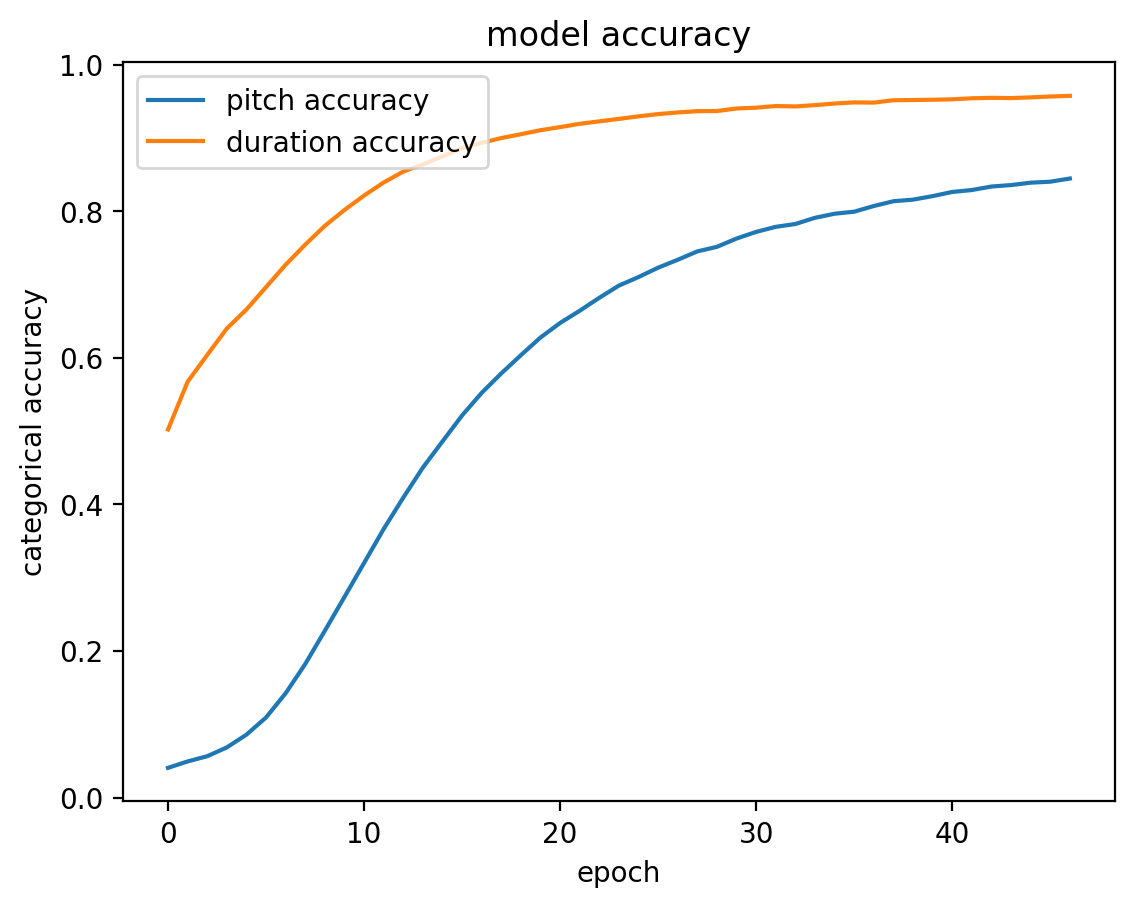

In [ ]:
plt.plot(history.history['pitch_categorical_accuracy'])
plt.plot(history.history['duration_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('categorical accuracy')
plt.xlabel('epoch')
plt.legend(['pitch accuracy', 'duration accuracy'], loc='upper left')
plt.show()

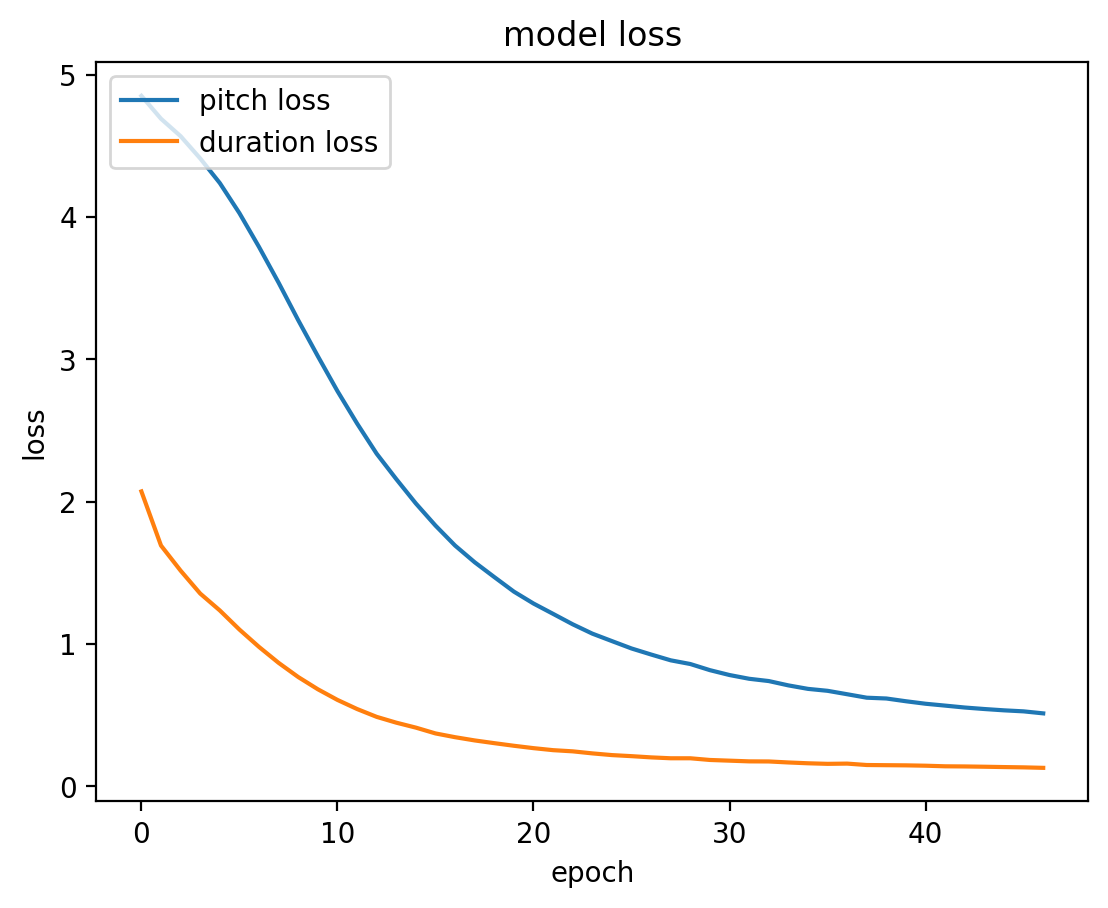

In [ ]:
plt.plot(history.history['pitch_loss'])
plt.plot(history.history['duration_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['pitch loss', 'duration loss'], loc='upper left')
plt.show()